# **Adversarial Projected Gradient Descent Analysis**
This notebook will analyze the Projected Gradient Descent method as an adversary to a trained neural network on CIFAR-100.

We trained two separate networks. The first was trained naturally, without seeing how an adversary might alter the input images.
The second was trained with the altered images.

We will display results for performance of the network against an adversarially altered test set as well as the natural test set.

We expect that the neural network that had training against adversarial inputs will have a higher accuracy on the
adversarially altered dataset than the naturally trained network. Furthermore, we expect the performance on the
natural test set to be similar for both networks.

We start by loading the data.

In [8]:
import torch
import torchvision

batch_size = 100
data_path = 'cifar100_data'
model_path = 'models/a_very_robust_model'
to_tensor = torchvision.transforms.PILToTensor()
to_double = torchvision.transforms.ConvertImageDtype(torch.double)
cifar_transform = torchvision.transforms.Compose([to_tensor,
                                                  to_double])
cifar_test_data = torchvision.datasets.CIFAR100(data_path,
                                                transform=cifar_transform,
                                                train=False,
                                                download=True)
test_data = torch.utils.data.DataLoader(cifar_test_data,
                                        batch_size=batch_size,
                                        shuffle=False)
                                                 

Files already downloaded and verified


Now we set up the network and load its pre-trained weights. One for the natural weights, the other for the adversarially trained weights.

In [9]:
from model import LeNet5


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# load model trained for 10,000 iterations (batches)
adv_model = LeNet5(100).double().to(device)
adv_model.load_state_dict(torch.load(model_path + '_adv_final_10000.pt', map_location=device))
adv_model.eval()
nat_model = LeNet5(100).double().to(device)
nat_model.load_state_dict(torch.load(model_path + '_nat_final_10000.pt', map_location=device))
nat_model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=100, bias=True)
  )
)

Now we define the attacker as our PGD adversary. We use the same parameters that were used when training the model, the most important being $\epsilon = 0.0313725$.

In [10]:
from pgd_attack import LinfPGDAttack

epsilon = 0.0313725
num_steps = 5
step_size = 0.008
random_start = True

adv_attack = LinfPGDAttack(adv_model,
                           epsilon,
                           num_steps,
                           step_size,
                           random_start)

nat_attack = LinfPGDAttack(nat_model,
                           epsilon,
                           num_steps,
                           step_size,
                           random_start)

Next we compute the predictions that each network has on both the natural and altered test sets.

In [20]:
import torchmetrics as tm
from tqdm import tqdm

nat_nat_acc_func = tm.Accuracy()
adv_nat_acc_func = tm.Accuracy()
nat_adv_acc_func = tm.Accuracy()
adv_adv_acc_func = tm.Accuracy()

view_flag = True

for x_batch, y_batch in tqdm(iter(test_data)):
    nat_nat_preds = nat_model(x_batch)
    adv_nat_preds = adv_model(x_batch)
    
    x_batch_adv_nat = nat_attack.perturb(x_batch, y_batch)
    x_batch_adv_adv = adv_attack.perturb(x_batch, y_batch)
    
    if view_flag:
        nat_image = x_batch[0]
        adv_nat_image = x_batch_adv_nat[0]
        adv_adv_image = x_batch_adv_adv[0]
        label = y_batch[0]
        view_flag = False

    nat_adv_preds = nat_model(x_batch_adv_nat)
    adv_adv_preds = adv_model(x_batch_adv_adv)

    nat_nat_acc_func.update(nat_nat_preds, y_batch)
    adv_nat_acc_func.update(adv_nat_preds, y_batch)
    nat_adv_acc_func.update(nat_adv_preds, y_batch)
    adv_adv_acc_func.update(adv_adv_preds, y_batch)

nat_nat_acc = nat_nat_acc_func.compute()
adv_nat_acc = adv_nat_acc_func.compute()
nat_adv_acc = nat_adv_acc_func.compute()
adv_adv_acc = adv_adv_acc_func.compute()

print(f'Natural accuracy on natural test set: {nat_nat_acc * 100 :.4}%')
print(f'PGD-trained accuracy on natural test set: {adv_nat_acc * 100 :.4}%')
print(f'Natural accuracy on altered test set: {nat_adv_acc * 100 :.4}%')
print(f'PGD-trained accuracy on altered test set: {adv_adv_acc * 100 :.4}%')

100%|██████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]

Natural accuracy on natural test set: 25.24%
PGD-trained accuracy on natural test set: 22.29%
Natural accuracy on altered test set: 1.5%
PGD-trained accuracy on altered test set: 13.55%


So the accuracy is not that great overall, but this makes sense since we are using a fairly simple network for this problem.
The main thing to notice is that the PGD-trained network accuracy was much higher than the naturally trained accuracy on the altered test set.
This means that our training was helpful against this particular PGD adversary.

Here is one example image (a mountain) unaltered, altered against the naturally trained network, and altered against the PGD-trained network:

Image true label: 49


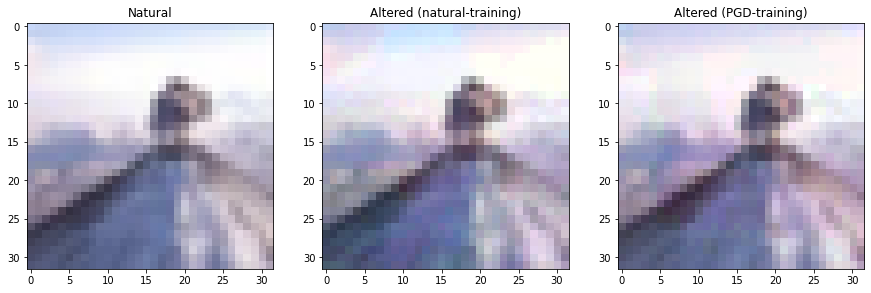

In [22]:
import matplotlib.pyplot as plt

print(f'Image true label: {label}')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(torch.moveaxis(nat_image, 0, 2))
ax1.set_title('Natural')
ax2.imshow(torch.moveaxis(adv_nat_image, 0, 2))
ax2.set_title('Altered (natural-training)')
ax3.imshow(torch.moveaxis(adv_adv_image, 0, 2))
ax3.set_title('Altered (PGD-training)')
plt.show()

All of these images are nearly indistinguishable, yet the naturally-trained network does only marginally better than random at classifying the center image.